In [5]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from turtle import down
from torchvision.transforms.functional import normalize
from PIL import Image

from distutils.log import error
from basicsr.utils import imwrite, scandir
from basicsr.utils.download_util import load_file_from_url
from basicsr.utils import imwrite, img2tensor, tensor2img, scandir
from basicsr.archs.zerodce_arch import ConditionZeroDCE
from basicsr.utils.registry import ARCH_REGISTRY


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Display the images

def display_images_side_by_side(image1_path, image2_path):
    # Open the images
    image1 = Image.open(image1_path)
    image2 = Image.open(image2_path)
    
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display the first image on the first subplot
    axes[0].imshow(image1)
    axes[0].axis('off')  # Hide axes for a cleaner look
    axes[0].set_title("Original Image")

    # Display the second image on the second subplot
    axes[1].imshow(image2)
    axes[1].axis('off')
    axes[1].set_title("Processed Image")
    
    # Show the figure
    plt.show()

In [7]:
def resize_image(image, max_size=1440):
    
    # Get the original dimensions
    height, width = image.shape[:2]
    
    # Calculate the scaling factor to resize while keeping the aspect ratio
    scale = max_size / max(width, height)
    
    # Calculate new dimensions
    new_width = int(width * scale)
    new_height = int(height * scale)
    
    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height) )# , interpolation=cv2.INTER_AREA)
    
    return resized_image

# Generate low-light images

In [8]:
test_path = 'demo/input'
result_path = 'demo/darken'
model_path ='weights/ce_zerodce.pth'
ckpt_path = 'weights/ce_zerodce.pth'

if test_path.endswith('/'):  # solve when path ends with /
    test_path = test_path[:-1]
if result_path.endswith('/'):  # solve when path ends with /
    result_path = result_path[:-1]
result_root = f'{result_path}/{os.path.basename(test_path)}'

In [9]:
threshold = 0.97 # threshold for saturated regions
exp_range = [0.05, 0.3]
# exp_range = [0.1, 0.3]

In [10]:
# ------------------ set up EC-ZeroDCE network -------------------
net = ConditionZeroDCE().to(device)
checkpoint = torch.load('weights/ce_zerodce.pth', map_location=device, weights_only=True)
net.load_state_dict(checkpoint)
net.eval()

ConditionZeroDCE(
  (relu): ReLU(inplace=True)
  (e_conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv5): Conv2d(768, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv6): Conv2d(768, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv7): Conv2d(768, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
  (e_conv_e1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv_e2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv_e3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

In [11]:
# img_path = sorted(list(scandir(test_path, suffix=('jpg', 'png'), recursive=True, full_path=True))).pop()
img_path = 'demo/input/test_input_normal.jpg'
# img_name = img_path.replace(test_path+'/', '')
# print(f'Processing: {img_name}')
img = cv2.imread(img_path, cv2.IMREAD_COLOR)

#resize image
img = resize_image(img)


# get random darkness
exp_degree = random.uniform(*exp_range)

# inference
img = img.astype('float32')/255.0
h,w,_ = img.shape
img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
l_channel, a_channel, b_channel = cv2.split(img_lab)
l_channel_t = torch.from_numpy(l_channel).view(1,1,h,w).to(device)
l_channel_f = l_channel_t/100.0
exp_map = exp_degree * torch.ones_like(l_channel_f)
stuated_map = (l_channel_f>threshold).int()
exp_map = exp_map*(1-stuated_map) + l_channel_f*stuated_map

with torch.no_grad():
    low_light_l = (net(l_channel_f, exp_map)*100).squeeze().cpu().detach().numpy()

scale = low_light_l/(l_channel+1e-8)
scale = np.dstack([scale]*3)
low_light_img = img*scale*255

img_out = low_light_img.clip(0,255).astype('uint8')

# save darken img
save_restore_path = img_path.replace(test_path, result_path)
imwrite(img_out, save_restore_path)

True

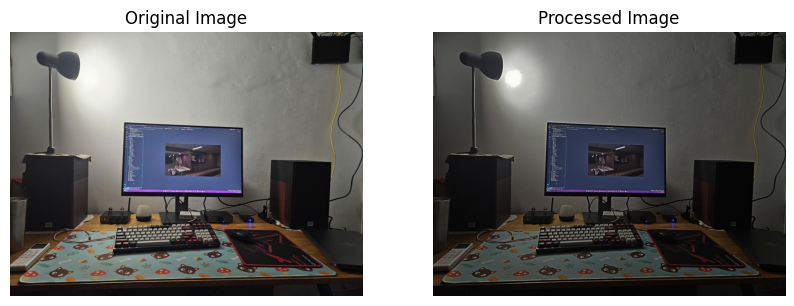

In [12]:
display_images_side_by_side(img_path, save_restore_path)

# Enchance and de-blur

In [13]:
def check_image_size(x, down_factor):
    _, _, h, w = x.size()
    mod_pad_h = (down_factor - h % down_factor) % down_factor
    mod_pad_w = (down_factor - w % down_factor) % down_factor
    x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
    return x

In [14]:
# ------------------ set up LEDNet network -------------------
down_factor = 8
net = ARCH_REGISTRY.get('LEDNet')(channels=[32, 64, 128, 128], connection=False).to(device)
ckpt_path = 'weights/lednet.pth'
# ckpt_path = 'weights/lednet_retrain_500000.pth'
checkpoint = torch.load('weights/lednet.pth', map_location=device, weights_only=True)['params']
net.load_state_dict(checkpoint)
net.eval()

LEDNet(
  (E_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BasicBlock_E(
      (body1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=1)
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (body2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=1)
      )
      (reshape_conv): ResidualDownSample(
        (top): Sequential(
          (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): PReLU(num_parameters=1)
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (3): PReLU(num_parameters=1)
          (4): Downsample(
            (pad): ReflectionPad2d((1, 1, 1, 1))
          )
          (5): Conv2d(32, 64, kernel_size=(1, 1), 

In [15]:
img_path = 'demo/brighten/input/test_brighten.jpg'
model = 'lednet'


img = cv2.imread(img_path, cv2.IMREAD_COLOR)
# img = resize_image(img)

# prepare data
img_t = img2tensor(img / 255., bgr2rgb=True, float32=True)

# without [-1,1] normalization in lednet model (paper version) 
if not model == 'lednet':
    normalize(img_t, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)

img_t = img_t.unsqueeze(0).to(device)

# lednet inference
with torch.no_grad():
    # check_image_size
    H, W = img_t.shape[2:]
    img_t = check_image_size(img_t, down_factor)
    output_t = net(img_t)
    output_t = output_t[:,:,:H,:W]

    if model == 'lednet':
        output = tensor2img(output_t, rgb2bgr=True, min_max=(0, 1))
    else:
        output = tensor2img(output_t, rgb2bgr=True, min_max=(-1, 1))

del output_t

output = output.astype('uint8')
# save restored img
save_restore_path = 'demo/brighten/output/test_brighten_result.jpg'
imwrite(output, save_restore_path)

True

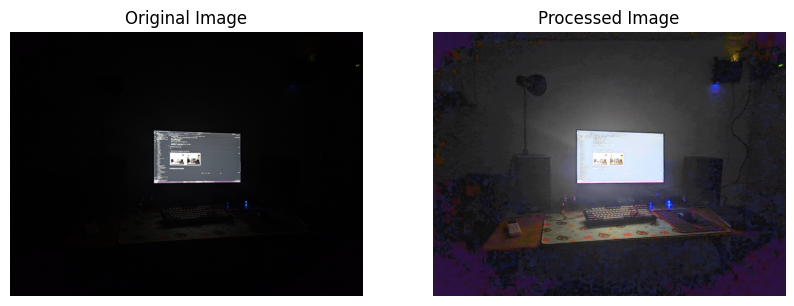

In [16]:
display_images_side_by_side(img_path, save_restore_path)